# Feature Importance Analysis
This notebook analyzes which features contribute most to the model's predictions. This helps in:
1. Understanding what the model is learning.
2. Identifying irrelevant features that can be removed (Feature Selection).
3. Debugging potential biases.


In [1]:
import sys
from pathlib import Path
import importlib
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

# Setup Project Path
p = Path.cwd().parent
if str(p) not in sys.path:
    sys.path.insert(0, str(p))


In [3]:
# 2. Load Processed Data (Filtered + Interactions)
# This uses get_filtered_data which handles Loading -> Filtering -> Interaction Generation
vectors_path = resolve_path(config["vectors_file"])
scores_path = resolve_path(config["scores_file"])

X, y, kept_features, _ = get_filtered_data(vectors_path, scores_path)
print(f"Loaded {len(X)} samples with {X.shape[1]} features (filtered from raw).")

Loading processed data from cache: C:\ComfyUI\trainer\training\output\processed_data_cache.npz
Data ready (cached). Shape: (20, 873)
Loaded 20 samples with 873 features (filtered from raw).


In [5]:
from training.run import grid_base

top_cfg = config["training"].get("top")
# verbosity=config["training"]["verbosity"]
verbosity=-1
params = {}
# Dynamic parameter loading from grid_base
for key in grid_base.keys():
    # Only load if key exists in top_cfg, otherwise use default
    if key in top_cfg:
        params[key] = top_cfg[key]

# Remove early_stopping_rounds if present, as we don't have a validation set here
if "early_stopping_rounds" in params:
    del params["early_stopping_rounds"]

# Train LightGBM
print("Training Model...")
model = lgb.LGBMRegressor(**params, verbose=verbosity)
model.fit(X, y)
print("Training Complete.")

Training Model...
Training Complete.


Detected Image Vector Length: -681
Total Feature Names: 1554


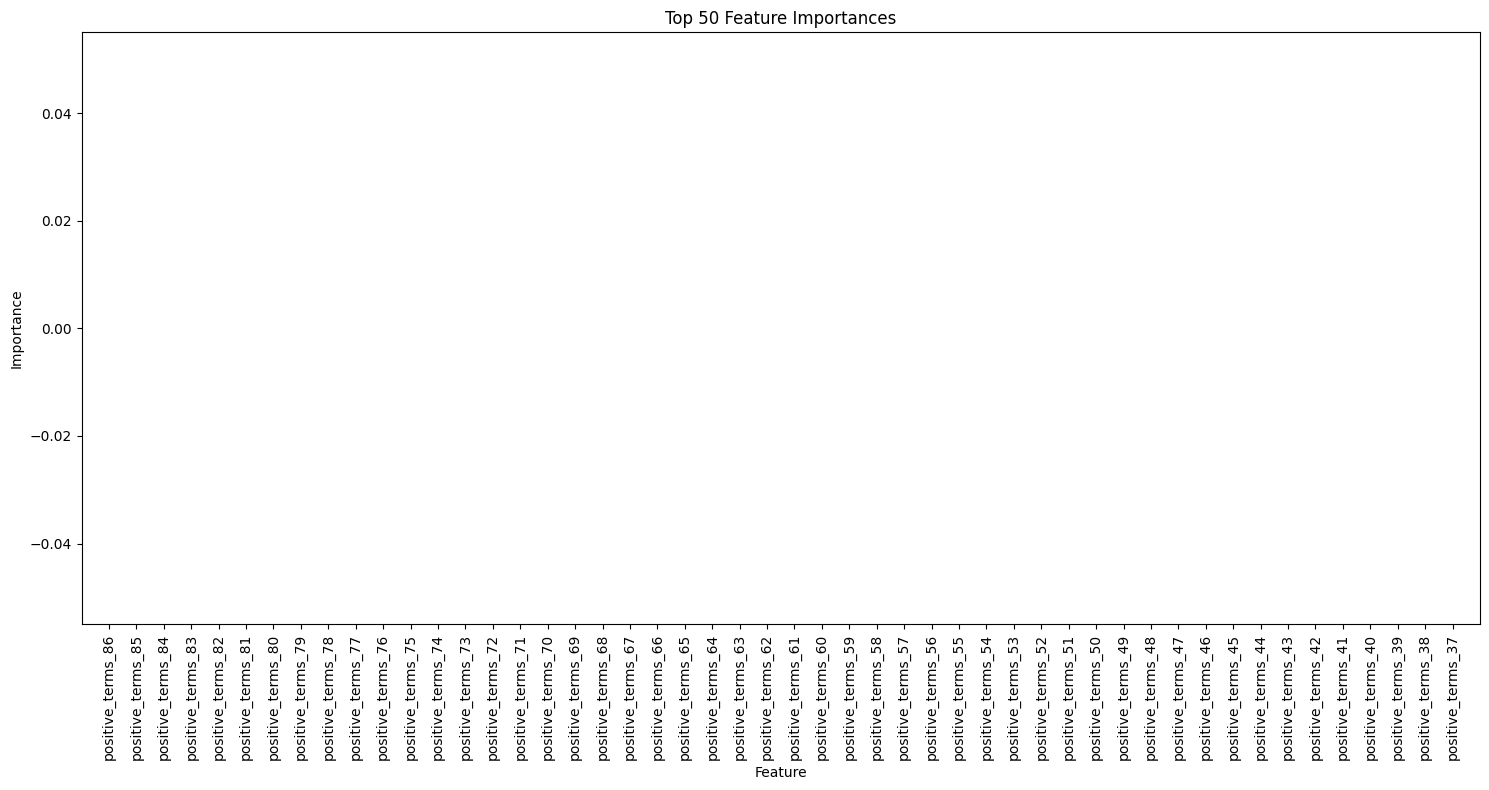

Most important features: ['positive_terms_86', 'positive_terms_85', 'positive_terms_84', 'positive_terms_83', 'positive_terms_82', 'positive_terms_81', 'positive_terms_80', 'positive_terms_79', 'positive_terms_78', 'positive_terms_77']


In [6]:
# Plot Feature Importances
import json

# Reconstruct Feature Names
# 1. Load Schema
with open(resolve_path(config["prepare_config"]), "r") as f:
    prep_config = json.load(f)

schema = prep_config["vector_schema"]
order = schema["order"]
slots = schema["slots"]
mode = prep_config["prompt_representation"]["mode"]
dim = prep_config["prompt_representation"]["dim"]

feature_names = []

# 2. Add Image Vector Features (Prepended in processing.py)
# Standard CLIP ViT-B/32 is 512. We can estimate it or just assume it.
# Calculating: Total loaded features - Sum of constructed features = Image features
constructed_len = 0
for name in order:
    size = 0
    if name in ("positive_terms", "negative_terms") and mode == "embedding":
        size = dim
    else:
        size = slots.get(name, 0)
    constructed_len += size

image_vec_len = X.shape[1] - constructed_len
print(f"Detected Image Vector Length: {image_vec_len}")
for i in range(image_vec_len):
    feature_names.append(f"image_clip_{i}")

# 3. Add Assembled Features
for name in order:
    size = 0
    if name in ("positive_terms", "negative_terms") and mode == "embedding":
        size = dim
    else:
        size = slots.get(name, 0)
    
    if size == 1:
        feature_names.append(name)
    else:
        for i in range(size):
            feature_names.append(f"{name}_{i}")

print(f"Total Feature Names: {len(feature_names)}")

# Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 50

top_indices = indices[:top_n]
top_names = [feature_names[i] if i < len(feature_names) else f"Unknown_{i}" for i in top_indices]

plt.figure(figsize=(15, 8))
plt.title(f"Top {top_n} Feature Importances")
plt.bar(range(top_n), importances[top_indices], align="center")
plt.xticks(range(top_n), top_names, rotation=90)
plt.xlim([-1, top_n])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

print("Most important features:", top_names[:10])


In [7]:
# Dimension Reduction Analysis (Bonus)
# Check how many features have 0 importance
zero_importance_count = np.sum(importances == 0)
print(f"Features with Zero Importance: {zero_importance_count} / {len(importances)}")
print(f"Percentage of Useless Features: {100 * zero_importance_count / len(importances):.2f}%")

if zero_importance_count > 0:
    print("Suggestion: You can drop these features to speed up training without losing accuracy.")


Features with Zero Importance: 873 / 873
Percentage of Useless Features: 100.00%
Suggestion: You can drop these features to speed up training without losing accuracy.


In [8]:
# Identify Zero Importance Features
zero_indices = np.where(importances == 0)[0]
zero_names = [feature_names[i] if i < len(feature_names) else f"Unknown_{i}" for i in zero_indices]

# Print summary of zero importance features by category
category_counts = {}
for name in zero_names:
    category = "image_clip" if name.startswith("image_clip") else name.split("_")[0]
    category_counts[category] = category_counts.get(category, 0) + 1

print("\n--- Zero Importance Features by Category ---")
for cat, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cat}: {count} unused features")

print("\n--- Detailed List (First 20) ---")
print(zero_names[:20])



--- Zero Importance Features by Category ---
negative: 768 unused features
positive: 87 unused features
model: 4 unused features
sampler: 3 unused features
scheduler: 3 unused features
steps: 2 unused features
lora: 2 unused features
cfg: 1 unused features
width: 1 unused features
height: 1 unused features
aspect: 1 unused features

--- Detailed List (First 20) ---
['cfg', 'steps', 'lora_weight', 'steps_cfg', 'lora', 'sampler_0', 'sampler_1', 'sampler_2', 'scheduler_0', 'scheduler_1', 'scheduler_2', 'model_0', 'model_1', 'model_2', 'model_3', 'width', 'height', 'aspect_ratio', 'negative_terms_0', 'negative_terms_1']


In [9]:
# Check Interaction Feature (steps_cfg)
try:
    interaction_idx = feature_names.index("steps_cfg")
    interaction_importance = importances[interaction_idx]
    print(f"\nSteps*CFG Importance Details:")
    print(f"Importance Score: {interaction_importance}")
    
    # Rank
    rank = np.where(indices == interaction_idx)[0][0]
    print(f"Rank: {rank} / {len(importances)}")
except ValueError:
    print("steps_cfg feature not found in feature list.")


Steps*CFG Importance Details:
Importance Score: 0
Rank: 869 / 873


Total Features: 1554
Features needed for 95% Importance: 1
Features needed for 99% Importance: 1


C:\Users\pskyv\AppData\Local\Temp\ipykernel_27928\2708759537.py:8: RuntimeWarning: invalid value encountered in divide
  cumulative_ratios = cumulative_importances / total_importance


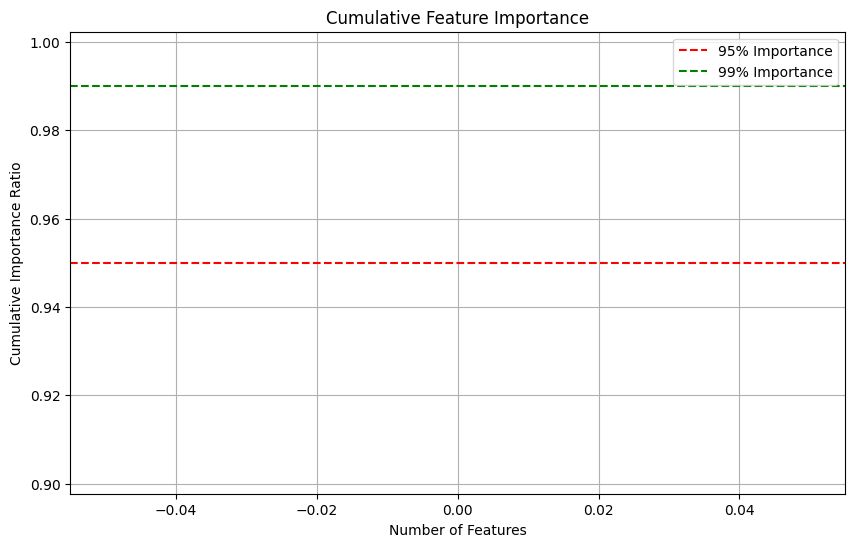

c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



--- Retraining Verification ---
Original Shape: (20, 873)
Reduced Shape:  (20, 0)

Training Baseline (All Features)...
Baseline R2: -0.5786

Training Reduced Model (Non-zero Features only)...


ValueError: Found array with 0 feature(s) (shape=(16, 0)) while a minimum of 1 is required by LGBMRegressor.

In [10]:
# --- ACTIONABLE NEXT STEPS ---

# 1. Cumulative Importance Analysis
# Let's see how many features are actually needed to reach 95% or 99% of the total importance.
sorted_importances = np.sort(importances)[::-1]
cumulative_importances = np.cumsum(sorted_importances)
total_importance = np.sum(importances)
cumulative_ratios = cumulative_importances / total_importance

n_95 = np.argmax(cumulative_ratios >= 0.95) + 1
n_99 = np.argmax(cumulative_ratios >= 0.99) + 1

print(f"Total Features: {len(feature_names)}")
print(f"Features needed for 95% Importance: {n_95}")
print(f"Features needed for 99% Importance: {n_99}")

plt.figure(figsize=(10, 6))
plt.plot(cumulative_ratios)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Importance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Importance')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance Ratio')
plt.legend()
plt.grid(True)
plt.show()

# 2. Retrain with Reduced Feature Set (Verification)
# We will drop all zero-importance features and see if the R2 score holds up.
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

print("\n--- Retraining Verification ---")

# Identify effective features (Importance > 0)
effective_mask = importances > 0
X_reduced = X[:, effective_mask]
reduced_feature_names = [name for name, keep in zip(feature_names, effective_mask) if keep]

print(f"Original Shape: {X.shape}")
print(f"Reduced Shape:  {X_reduced.shape}")

# Split both sets to compare fairly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train Baseline
print("\nTraining Baseline (All Features)...")
model_full = lgb.LGBMRegressor(**params, verbose=-1)
model_full.fit(X_train, y_train)
preds_full = model_full.predict(X_test)
r2_full = r2_score(y_test, preds_full)
print(f"Baseline R2: {r2_full:.4f}")

# Train Reduced
print("\nTraining Reduced Model (Non-zero Features only)...")
model_red = lgb.LGBMRegressor(**params, verbose=-1)
model_red.fit(X_red_train, y_red_train)
preds_red = model_red.predict(X_red_test)
r2_red = r2_score(y_red_test, preds_red)
print(f"Reduced R2:  {r2_red:.4f}")

diff = r2_red - r2_full
print(f"\nDifference: {diff:.4f}")
if diff > -0.01:
    print("CONCLUSION: Safe to drop unused features. Performance is maintained.")
else:
    print("CONCLUSION: Careful! Dropping features hurt performance slightly.")